<a href="https://colab.research.google.com/github/ContiPaolo/EKF-SINDy/blob/main/CoupledOscillators_CouplingEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###########################  CLONE EKF-SINDY AND INSTALL PACKAGES  ###########################
from IPython.display import clear_output
import sys
sys.path.append('/content/EKF-SINDy')
print("Clone EKF-SINDy repository and install usefull packages")
!git clone https://github.com/ContiPaolo/EKF-SINDy
!pip install pysindy pyDOE filterpy
#Stable version:
#!pip install pysindy==1.3.0 pyDOE==0.3.8 filterpy scikit-learn==0.24.1
clear_output()
print("EKF-SINDy ready to go :)")

EKF-SINDy ready to go :)


In [2]:
###########################                LIBRARIES                ###########################
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from scipy.integrate import odeint
from scipy.linalg import hankel
from pyDOE import lhs
from scipy.io import savemat
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

from utils_EKFSINDy import add_noise_with_snr, jacobian_A, jacobian_H

seed = 1

## Coupled Oscillators:
### Estimation of linear and quadratic coupling parmaeters $\alpha$ and $\beta$.

We consider two coupled oscillators with the following equations of motion:

$$
\begin{align}
& m_1\ddot{u}_1 + c_1 \dot{u}_1 + k_1 u_1 + \alpha u_2 = 0, \\
& m_2\ddot{u}_2 + c_2 \dot{u}_2 + k_2 u_2 + \alpha u_1 + \beta u_1^2 + \gamma u_2^3 = 0,
\end{align}
$$

which can be rewritten at first order as:

$$
\begin{align}
\dot{u}_1 &= v_1, \\
m_1\dot{v}_1 &= -c_1 v_1 - k_1 u_1 - \alpha u_2, \\
\dot{u}_2 &= v_2, \\
m_2\dot{v}_2 &= - c_2 v_2 - k_2 u_2 - \alpha u_1 - \beta u_1^2 - \gamma u_2^3.
\end{align}
$$

We suppose we are only able to measure the position of the first oscillator $u_1$, and we aim to:

1. **Identify the equations of motion from the data (SINDy)**
2. **Estimate the states and the linear and quadratic coupling parameters, $\alpha$ and $\beta$.**

In [3]:
######################       PROBLEM SETUP       ######################

system = {
    #Natural frequency of the oscillators:
    'k1' : (1.)**2,
    'k2' : (1.95)**2,

    #Damping:
    'c1' : 2e-2,
    'c2' : 1.95e-2,

    #Coupling:
    #To be estimated

    #Cubic nonlinearity:
    'gamma' : 1e-3,

    #Time span:
    't0' : 0.,
    'T' : 200.,

    #Time step:
    'dt' : 1e-2
}

#Define the right-hand side of the ODE:
def f(y,t, system = system, forced = True):

    u1, v1, u2, v2 = y

    #Retrieve parameters:
    c1 = system['c1']
    c2 = system['c2']
    k1 = system['k1']
    k2 = system['k2']
    gamma = system['gamma']
    beta = system['beta']
    alpha = system['alpha']

    du1 = v1
    dv1 = - k1*u1 - c1*v1  - alpha*u2
    du2 = v2
    dv2 = - k2*u2 - c2*v2 - beta*(u1**2) - alpha*u1 - gamma*(u2**3)

    return np.array([du1, dv1, du2, dv2])

#Define the time frame:
t0, T, dt = system['t0'], system['T'], system['dt']

t = np.arange(t0,T,dt)
Nt = len(t)


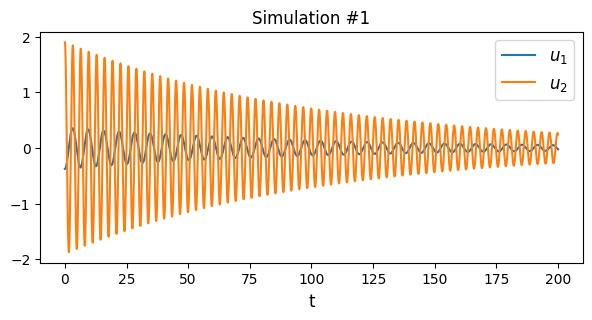

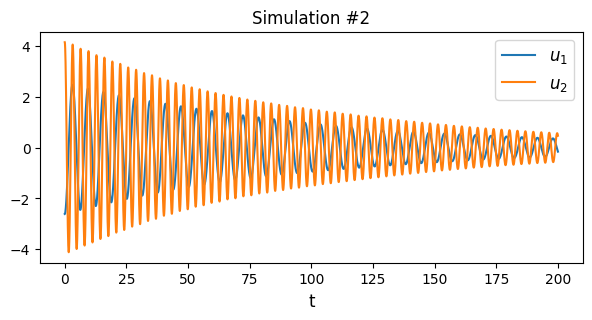

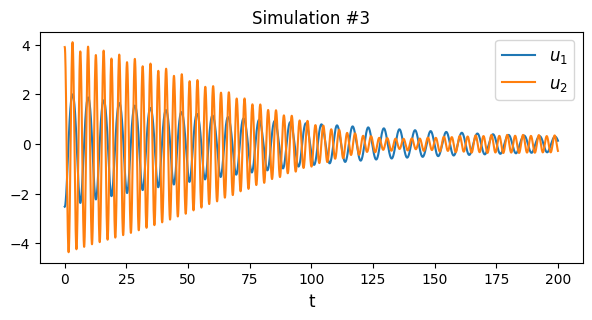

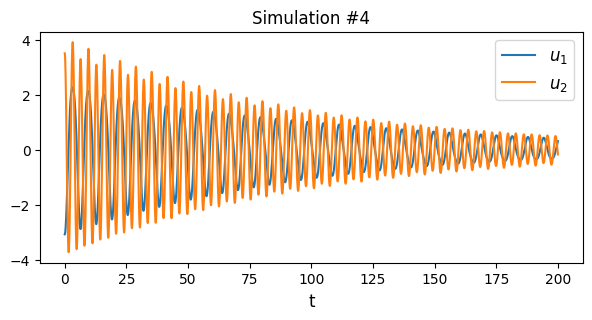

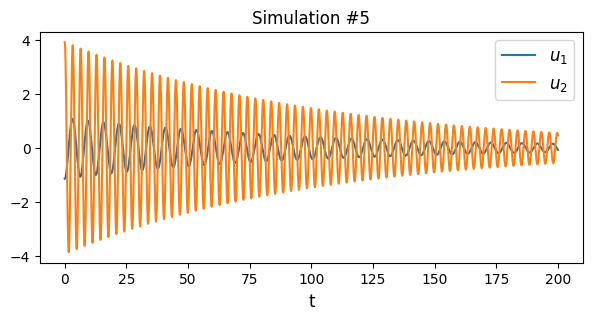

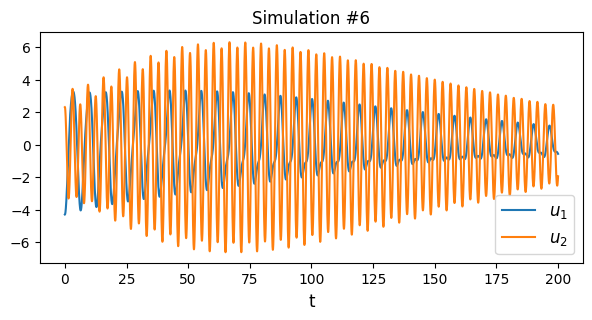

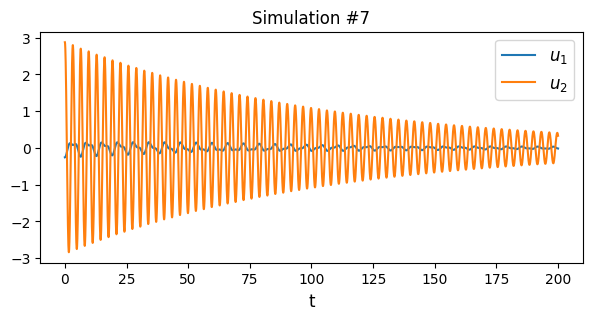

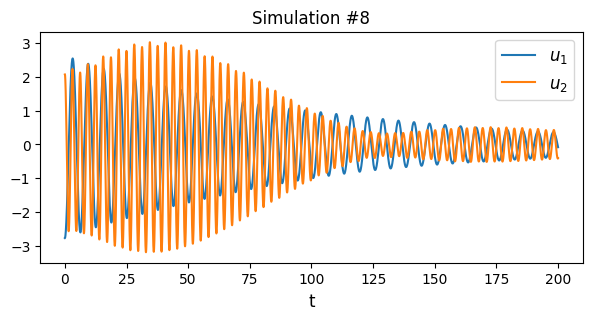

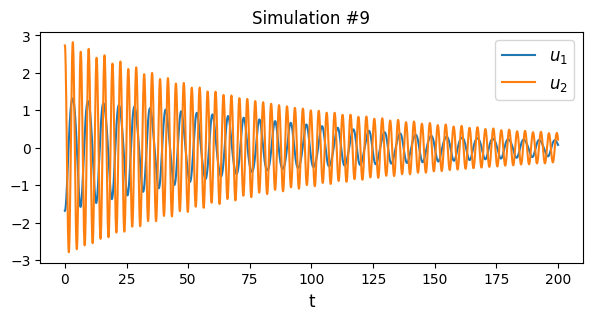

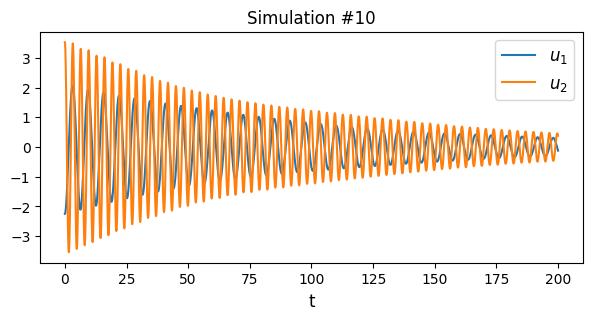

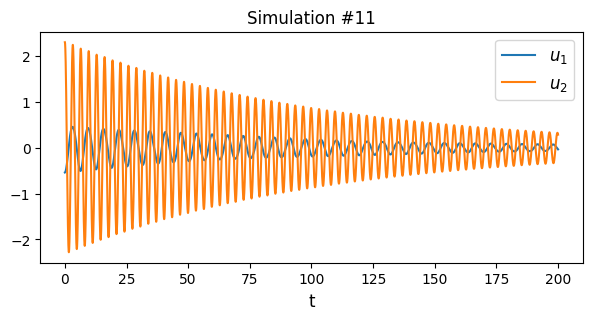

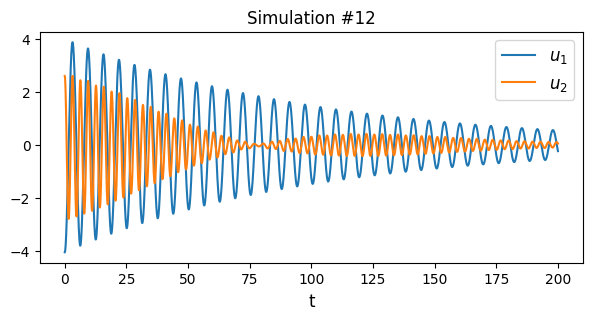

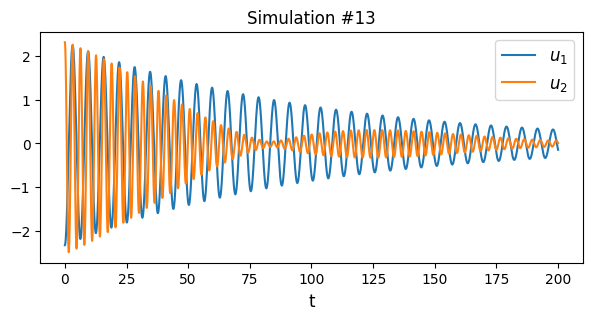

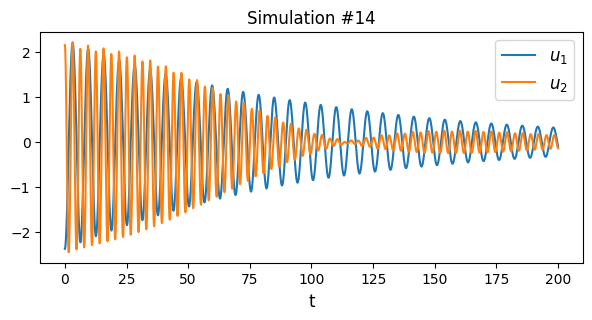

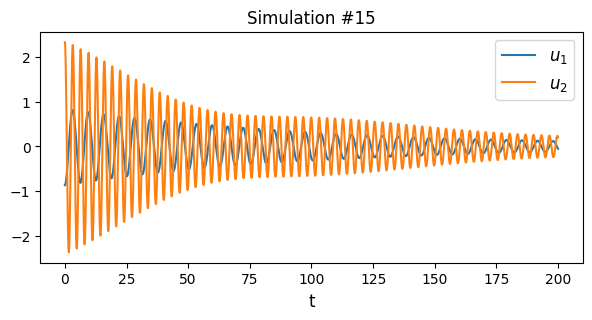

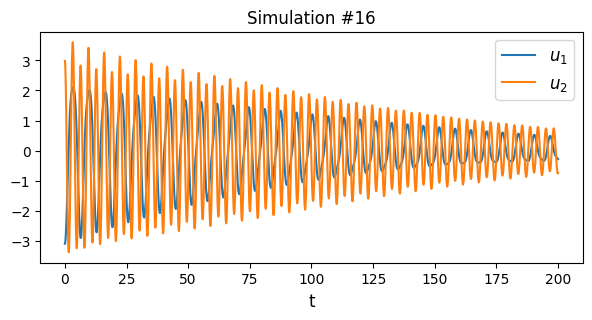

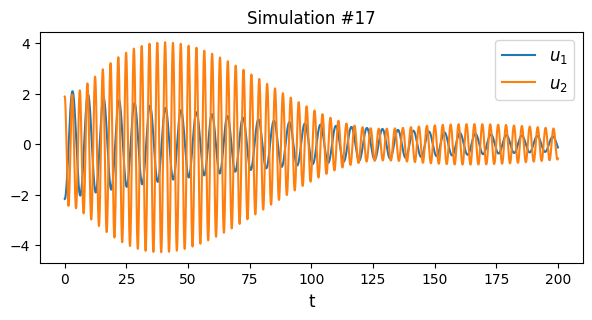

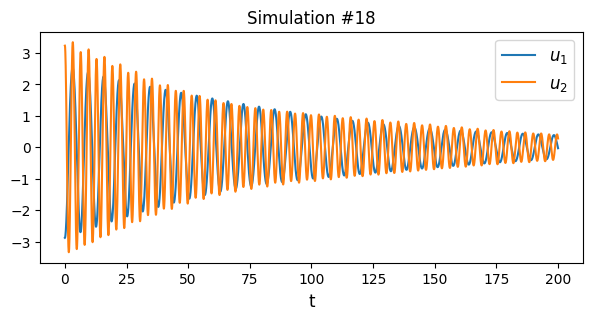

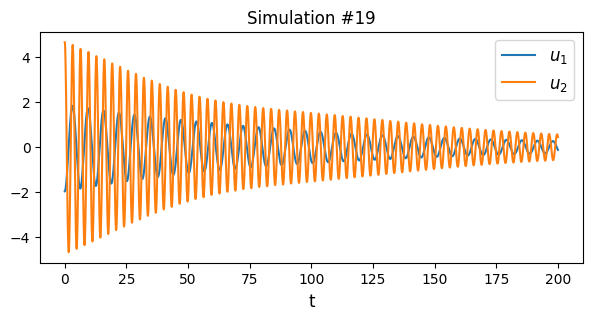

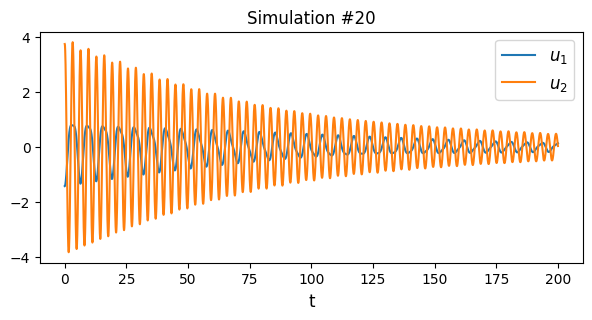

In [4]:
######################       GENERATE DATA       ######################
#Number of instances
n_ics = 20

#Generate random intial conditions for the displacement, while we consider zero initial velocities:
np.random.seed(seed=seed)
u1_0 = np.random.normal(-2,1,n_ics)
u2_0 = np.random.normal(3,1,n_ics)

v1_0 = np.repeat(0.,n_ics)
v2_0 = np.repeat(0.,n_ics)

#Generate equispaced parameters for α and β, in the range Pα = [-0.05, -0.5] and Pβ =  [0.001, 0.01]
min_alpha, max_alpha = 0.005, 0.5
min_beta, max_beta = 0.005, 0.5
samples = lhs(2, samples=n_ics)
#Log space the data to have more samples in the lower range
alpha = np.log(min_alpha) + (np.log(max_alpha) - np.log(min_alpha))*samples[:,0]
beta = np.log(min_beta) + (np.log(max_beta) - np.log(min_beta))*samples[:,1]
alpha = -np.exp(alpha)
beta = np.exp(beta)

param_coupling = np.concatenate((alpha.reshape(-1,1), beta.reshape(-1,1)), axis = 1)


X = []

for num_sim in range(n_ics):
    #Set initial conditions:
    y0 = np.array([u1_0[num_sim], v1_0[num_sim], u2_0[num_sim], v2_0[num_sim]])
    #Retrieve coupling parameters:
    system['alpha'], system['beta'] = param_coupling[num_sim]
    #Solve the ODE:
    sol = odeint(f, y0, t)
    #Store the solution:
    X.append(sol)

    u1, v1, u2, v2 = np.hsplit(sol, 4)

    #Plot the solution:
    plt.figure(figsize=(7,3))
    plt.plot(t,u1, label = '$u_1$')
    plt.plot(t,u2, label = '$u_2$')
    plt.legend(fontsize = 12)
    plt.title('Simulation #' + str(num_sim+1), fontsize = 12)
    plt.xlabel('t', fontsize = 12)

    plt.show()

X = np.array(X)

#Split the data into training and test sets:
X_train, X_test, param_train, param_test = train_test_split(X, param_coupling, test_size=0.2, random_state=seed)
n_train, n_test = len(X_train), len(X_test)


Text(0.5, 0, '$\\lambda$')

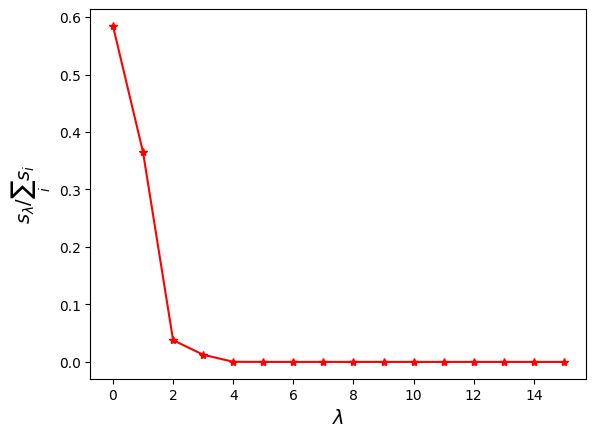

In [5]:
######################       TIME-DELAY EMBEDDING       ######################
def create_hankel(vector, length, shift = 1):
    p = len(vector)-(length*shift)+1
    H = vector[0:p]
    for i in range(1,length):
        H = np.vstack([H, vector[(i*shift):(i*shift)+p]])
    return H

#Create Hankel matrix from observations of u1:
length, shift = 200, 1

for i in range(n_train):
    u1 = X_train[i,:,0]
    H1 = create_hankel(u1.flatten(), length, shift)
    if i == 0:
        H = H1
    else:
        H = np.hstack([H,H1])

#Compute SVD:
uh, sh, vh = randomized_svd(H, n_components=16)

#Plot singular values:
plt.figure()
plt.plot(sh/np.sum(sh),'r*-')
plt.ylabel("$s_\lambda / \sum_{i}s_i$", fontsize = 14)
plt.xlabel("$\lambda$", fontsize = 14)

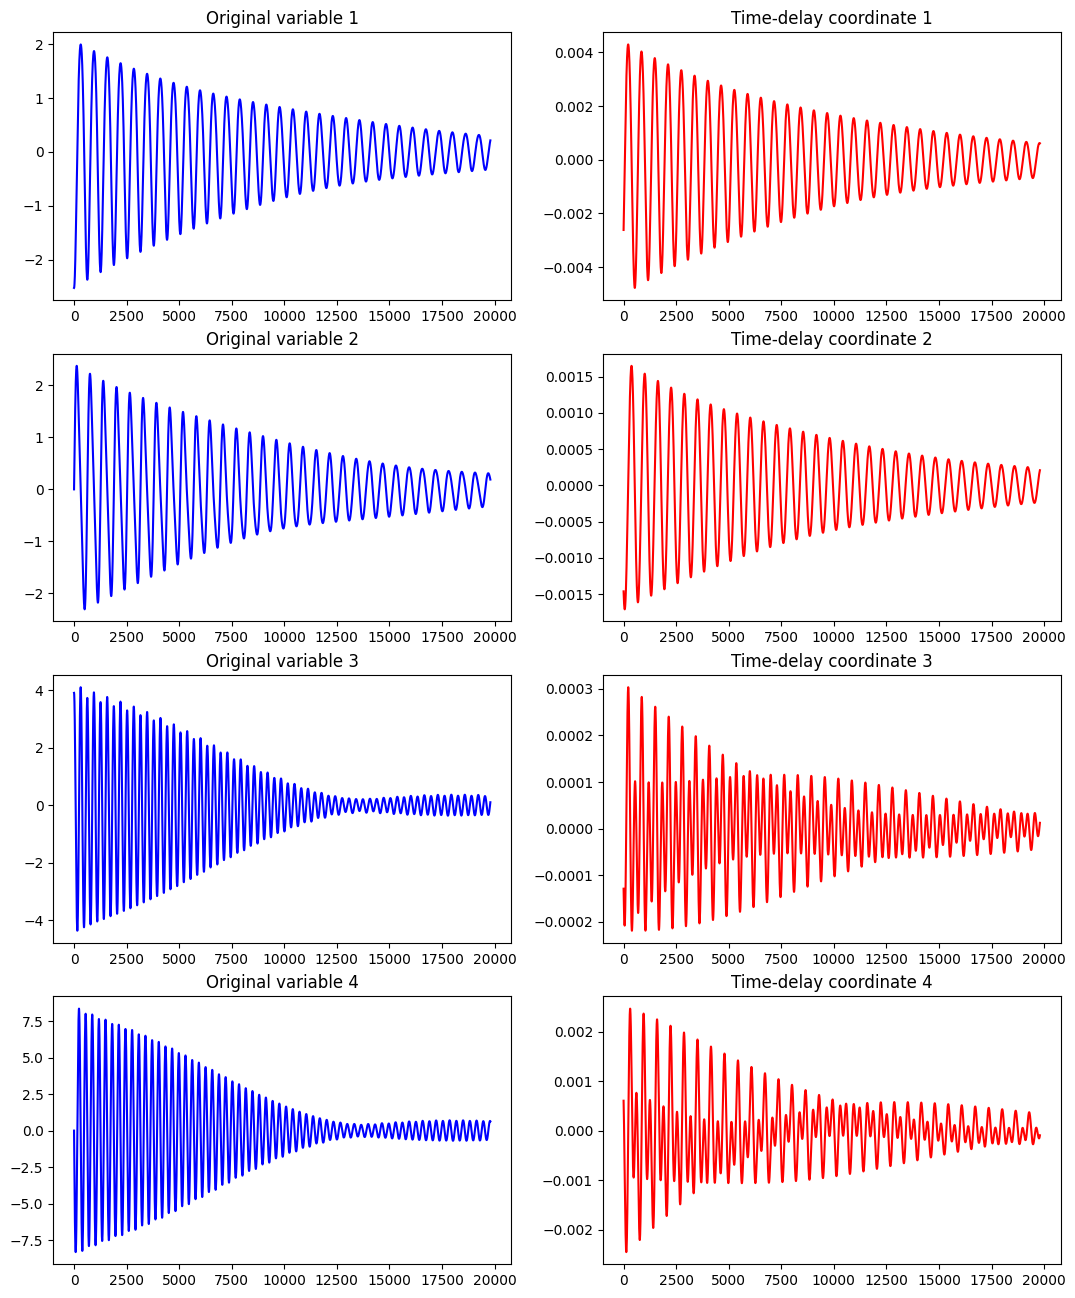

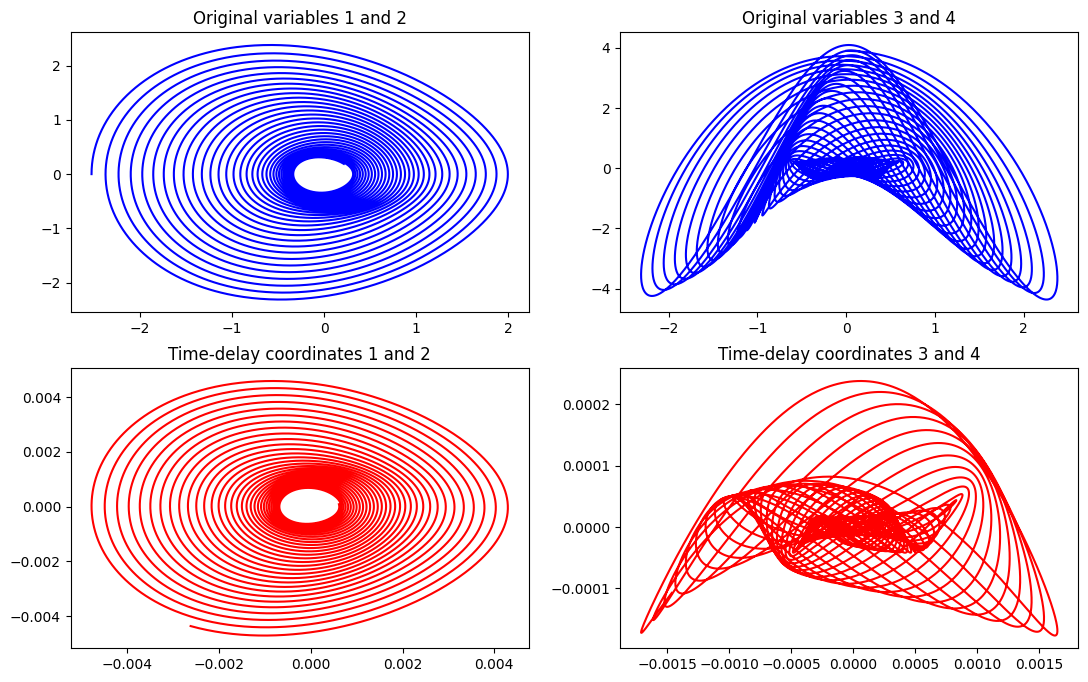

In [6]:
######################      TIME-DELAY COORDINATES       ######################
#Select the number of time-delay coordinates:
n_tdc = 4

U = uh[:,:n_tdc]
S = sh[:n_tdc]
Nt_h = Nt - length*shift + 1 #time length of the new coordinates

#Compute time-delay coordinates:
u_h = H.T @  (U * 1/S)

#Plot the first time-delay coordinate:
plt.figure(figsize = [13,16])
for i in range(4):
    plt.subplot(421 + 2*i)
    plt.plot(X_train[0,:Nt_h,i], 'b')
    plt.title(f'Original variable {i+1}', fontsize = 12)

    plt.subplot(421 + 2*i+1)
    plt.plot(u_h[i*Nt_h:(i+1)*Nt_h,i], 'r')
    plt.title(f'Time-delay coordinate {i+1}', fontsize = 12)

plt.figure(figsize = [13,8])
for i in range(2):
    plt.subplot(221 + i)
    plt.plot(X_train[0,:Nt_h,i], X_train[0,:Nt_h,i+1], 'b')
    plt.title(f'Original variables {2*i+1} and {2*i+2}', fontsize = 12)

    plt.subplot(221 +i + 2)
    plt.plot(u_h[i*Nt_h:(i+1)*Nt_h,i], u_h[i*Nt_h:(i+1)*Nt_h,i+1], 'r')
    plt.title(f'Time-delay coordinates {2*i+1} and {2*i+2}', fontsize = 12)

In [7]:
######################      PREPARE DATA for SINDy       ######################

X_tdc = []
dX_tdc = []
param_tdc = []

X_test_tdc = []
dX_test_tdc = []
param_test_tdc = []

for i in range(n_train):
    u1_ = X_train[i,:,0]
    H_ = create_hankel(u1_, length, shift)
    u_h = H_.T @  (U * 1/S)

    X_tdc.append(u_h[:,:n_tdc])
    dX_tdc.append(np.gradient(u_h[:,:n_tdc], dt, axis = 0))
    param_tdc.append(np.tile(param_train[i], (Nt,1))[:Nt_h])
    feature_names = ["u" + str(i+1) for i in range(n_tdc)]
    feature_names +=  ["a", "b"]

for i in range(n_test):
    u1_ = X_test[i,:,0]
    H_ = create_hankel(u1_, length, shift)
    u_h = H_.T @  (U * 1/S)

    X_test_tdc.append(u_h[:,:n_tdc])
    dX_test_tdc.append(np.gradient(u_h[:,:n_tdc], dt, axis = 0))
    param_test_tdc.append(np.tile(param_test[i], (Nt,1))[:Nt_h])

In [8]:
######################      CREATE SINDy model       ######################
model = ps.SINDy(feature_names  = feature_names, feature_library= ps.PolynomialLibrary(degree = 3, include_bias=False), optimizer=ps.STLSQ(threshold=1e-3))
model.fit(X_tdc, t=dt, multiple_trajectories=True, u = param_tdc, x_dot = dX_tdc)

model.print()
A = model.coefficients()
n_features = A.shape[1]

(u1)' = -0.006 u1 + -1.013 u2 + -0.001 u3 + -0.034 u4 + 0.001 u4 b + -0.001 u2 a^2 + -0.001 u2 a b + 0.001 u4 a^2 + 0.001 u4 a b
(u2)' = 0.996 u1 + -0.014 u2 + -0.343 u3 + 0.002 u1 a + 0.002 u3 a + 0.005 u3 b + -0.028 u1 a^2 + -0.007 u1 a b + -0.004 u1 b^2 + 0.007 u3 a^2 + 0.021 u3 a b + 0.011 u3 b^2
(u3)' = -0.003 u1 + 0.338 u2 + -0.001 u3 + -1.924 u4 + 0.002 u1 a + -0.002 u2 b + 0.011 u4 a + 0.015 u4 b + -0.042 u2 a^2 + -0.021 u2 a b + -0.012 u2 b^2 + 0.029 u4 a^2 + 0.059 u4 a b + 0.030 u4 b^2
(u4)' = 0.114 u1 + -0.004 u2 + 1.849 u3 + 0.029 u4 + 8.899 u1^2 + -0.422 u1 u4 + 0.089 u1 a + 0.035 u1 b + 0.290 u2 u3 + -0.008 u2 a + -0.478 u3 a + -0.285 u3 b + 0.916 u4^2 + 0.497 u4 a + -0.003 a^2 + -0.001 b^2 + -1.242 u1 a^2 + -0.244 u1 a b + -0.230 u1 b^2 + 0.086 u2 a^2 + -0.202 u2 a b + -0.759 u3 a^2 + -0.460 u3 a b + 1.501 u3 b^2 + 0.950 u4 a^2 + -0.392 u4 a b + -0.006 a^3 + 0.018 a^2 b + 0.002 b^3


Real parameters: [-0.27528572  0.00692449]


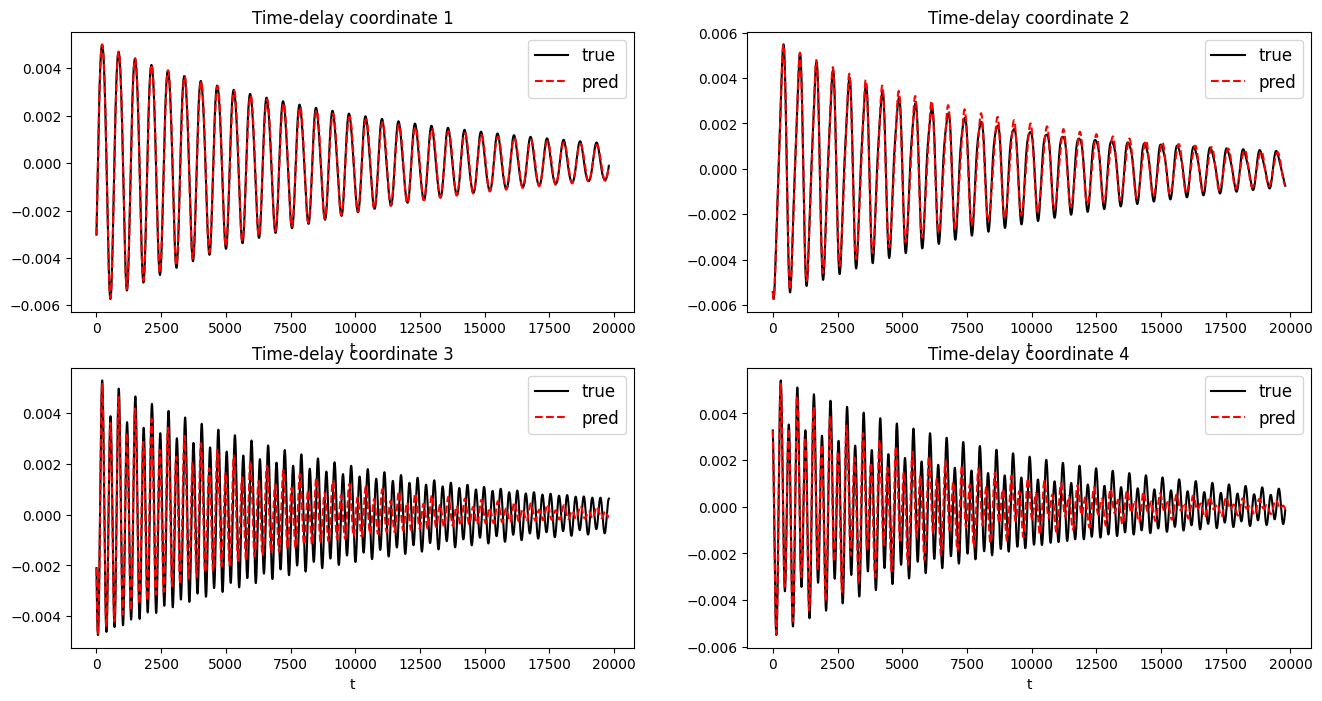

In [9]:
######################      PREDICT       ######################
idx_test = 0
correct_param = param_test_tdc[idx_test][0]
print('Real parameters:', correct_param)

#Predict the evolution of the time-delay coordinates:
test_params = np.tile(correct_param, (Nt_h,1))
pred = model.simulate(X_test_tdc[idx_test][0,:], t= t[:Nt_h], u = test_params)

#Plot the evolution of the time-delay coordinates:
plt.figure(figsize = [16,8])
for i in range(4):
    plt.subplot(221 +i)
    plt.plot(X_test_tdc[idx_test][:,i], 'k', label = 'true')
    plt.plot(pred[:,i], 'r--', label = 'pred')
    plt.title(f'Time-delay coordinate {i+1}', fontsize = 12)
    plt.xlabel('t')
    plt.legend(fontsize = 12)

MSE 0.007826406964153626


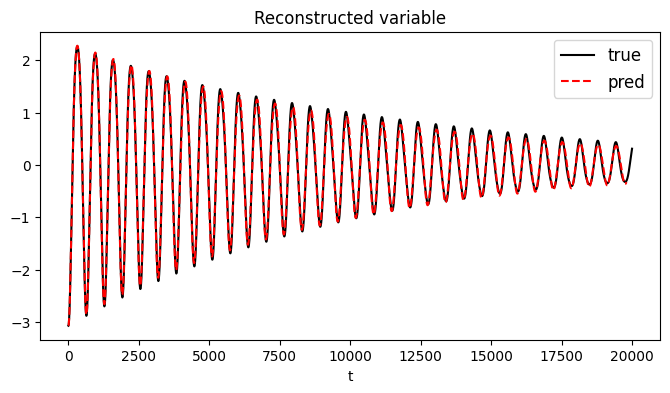

In [10]:
######################      RECONSTRUCTION       ######################
#Reconstruct observed variable:
x_rec = pred @ (U * S).T

#Plot the reconstructed variable:
plt.figure(figsize = [8,4])
plt.plot(X_test[idx_test,:,0], 'k', label = 'true')
plt.plot(x_rec[:,0], 'r--', label = 'pred')
plt.title(f'Reconstructed variable', fontsize = 12)
plt.xlabel('t')
plt.legend(fontsize = 12)

print('MSE', mean_squared_error(X_test[idx_test,:Nt_h-1,0], x_rec[:Nt_h,0]))


## Kalman Filter

In [11]:
# Kalman filter part - select the test case
param_a_rel_error = -0.9
param_b_rel_error = 19

idx_test = 0
correct_param = param_test_tdc[idx_test][0]

state_param = np.zeros(2)
state_param[0] = correct_param[0] *(1+param_a_rel_error)
state_param[1] = correct_param[1] *(1+param_b_rel_error)

N_x     = n_tdc # number of state variables is set as the number of time-delay coordinates
N_param = 2     # number of parameters to be identified
N_obs   = 1     # number of observed variables
N_l = Nt_h      # time length

add_noise = 1
snr_noise_displ = 15
snr_noise_veloc = 15

if add_noise:
    out_no_noise_axis = X_test[idx_test,:,0]
    out_axis = add_noise_with_snr(out_no_noise_axis,snr_noise_displ)
else:
    out_no_noise_axis = X_test[idx_test,:,0]
    out_axis = X_test[idx_test,:,0]


In [12]:
# Kalman filter initialisation

p0_x     = 1e-6
p0_param_1 = 1e-1
p0_param_2 = 1e-1

# process noise
q_x_1      = 5e-10
q_x_2      = 8e-8 #5e-8 #2e-8
q_x_3      = 8e-8 #5e-8 #3e-8
q_param  = 1e-11

# measurement noise
r_x_obs  = 3e-1


t_axis = np.arange(t0, (dt*N_l), dt)

xhat_taxis = np.zeros(shape=(N_x+N_param,N_l))
xhat_corr_taxis = np.zeros(shape=(N_x+N_param,N_l))
obs_taxis  = np.zeros(shape=(N_obs,N_l))
obs_check_taxis = np.zeros(shape=(N_obs,N_l))
P_taxis    = np.zeros(shape=(N_x+N_param,N_x+N_param,N_l))

xhat_taxis_piu_sigma  = np.zeros(shape=(N_x+N_param,N_l))
xhat_taxis_meno_sigma = np.zeros(shape=(N_x+N_param,N_l))

# inizialisation of the covariance matrix
I_cov = np.identity(N_x+N_param)
P = np.identity(N_x+N_param)
P[:N_x,:N_x] = P[:N_x,:N_x]*p0_x
P[-2,-2] = P[-2,-2]*p0_param_1
P[-1,-1] = P[-1,-1]*p0_param_2

# inizialisation of the process noise matrix
Q = np.identity(N_x+N_param)
Q[:2,:2] = Q[:2,:2]*q_x_1
Q[2,2] = Q[2,2]*q_x_2
Q[3,3] = Q[3,3]*q_x_3
Q[-N_param:,-N_param:] = Q[-N_param:,-N_param:]*q_param

# inizialisation of the measurement noise matrix
R = np.identity(N_obs)*r_x_obs

# identity matrix definition (dimension of the state variables)
I = np.zeros(shape=(N_x+N_param,N_x+N_param))
for i1 in range(N_x+N_param):
    I[i1,i1] = np.ones(1)

# inizialisation of the state vector
xhat = np.zeros(shape=(N_x+N_param))
xhat[0:N_x] = X_test_tdc[idx_test][0,:]
xhat[-N_param:] = state_param

xhat_taxis[:,0] = xhat
obs_taxis[0,0]  = out_axis[0]
obs_check_taxis[0,0]  = out_axis[0]
P_taxis[:,:,0]  = P

e_ = np.zeros(length)
e_[0] = 1

H = jacobian_H(U,S,N_x)

<ipython-input-12-3685162dc805>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  I[i1,i1] = np.ones(1)


In [13]:
# Kalman filter run
t_plus_1 = t0

for i0 in range(1,N_l):
    t_ = t_plus_1
    t_plus_1 = t_ + dt

    out = out_axis[i0]
    param = xhat[-N_param:]

    # Prediction phase
    xhat_pred = xhat[0:-N_param] + dt*(model.predict(xhat[0:-N_param].reshape(1,-1), xhat[-N_param:].reshape(1,-1)))
    xhat_pred = np.append(xhat_pred,param)
    F = jacobian_A(A,variables=xhat)

    P_pred = P + dt*(np.matmul(F,P) + np.matmul(P,F.transpose()) + Q)
    # end Predictor phase

    # Corrector phase
    # H = jacobian_H(U,S,N_x) Computed once for all
    G = np.matmul(np.matmul(P_pred,H.transpose()), np.linalg.inv(np.matmul(np.matmul(H,P_pred),H.transpose())+R) ) # Kalman gain computation
    obs = xhat_pred[:-N_param] @ (U * S).T @ (e_).T
    if N_obs == 1:
        xhat = xhat_pred + np.matmul(G, np.expand_dims(out-obs,axis=0) )
    else:
        xhat = xhat_pred + np.matmul(G, (out-obs) )

    obs_check = xhat[:-N_param] @ (U * S).T @ (e_).T

    P = np.matmul( np.matmul(I - np.matmul(G, H),  P_pred), (I - np.matmul(G, H)).transpose() ) + np.matmul(np.matmul(G,R),G.transpose())
    # end Corrector phase

    xhat_corr_taxis[:,i0] = np.matmul(G, np.expand_dims(out-obs,axis=0) )
    xhat_taxis[:,i0] = xhat
    obs_taxis[0,i0]  = obs
    obs_check_taxis[0,i0]  = obs_check
    P_taxis[:,:,i0]  = P


In [14]:
#%% Plot the results ##########################################################################
for i in range(N_x+N_param):
    # assumption - diagonal covariance matrix
    xhat_taxis_piu_sigma[i,:]  = xhat_taxis[i,:] + 1.96 * np.sqrt(P_taxis[i,i,:])
    xhat_taxis_meno_sigma[i,:] = xhat_taxis[i,:] - 1.96 * np.sqrt(P_taxis[i,i,:])

n_time_steps_start_plot = 0
n_time_steps_stop_plot = N_l

param_axis = np.zeros(shape=(N_l,2))
param_axis[:,0] = np.ones(N_l)*param_test_tdc[idx_test][0,0]
param_axis[:,1] = np.ones(N_l)*param_test_tdc[idx_test][0,1]


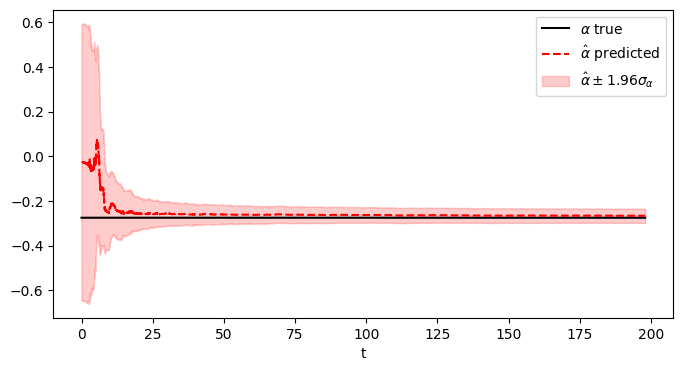

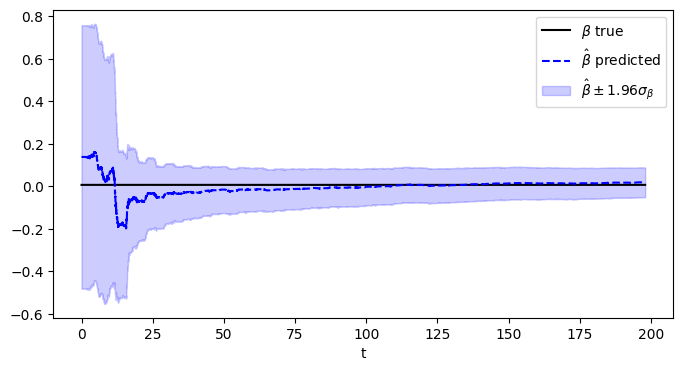

In [15]:
#%% alpha
param_index = N_x
plt.figure(figsize=[8, 4])
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], param_axis[n_time_steps_start_plot:n_time_steps_stop_plot, 0], 'k', label = r"$\alpha$ true")
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], 'r--', label = r"$\hat{\alpha}$ predicted")
plt.fill_between(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_piu_sigma[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_meno_sigma[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], color='red', alpha=0.2, label = r"$\hat{\alpha} \pm 1.96\sigma_\alpha$")
plt.xlabel('t')
plt.legend()

#%% beta
param_index = N_x +1
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], param_axis[n_time_steps_start_plot:n_time_steps_stop_plot, 1], 'k', label = r"$\beta$ true")
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], 'b--', label = r"$\hat{\beta}$ predicted")
plt.fill_between(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_piu_sigma[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_meno_sigma[param_index, n_time_steps_start_plot:n_time_steps_stop_plot], color='blue', alpha=0.2, label = r"$\hat{\beta} \pm 1.96\sigma_\beta$")
plt.xlabel('t')
plt.legend()
plt.show()


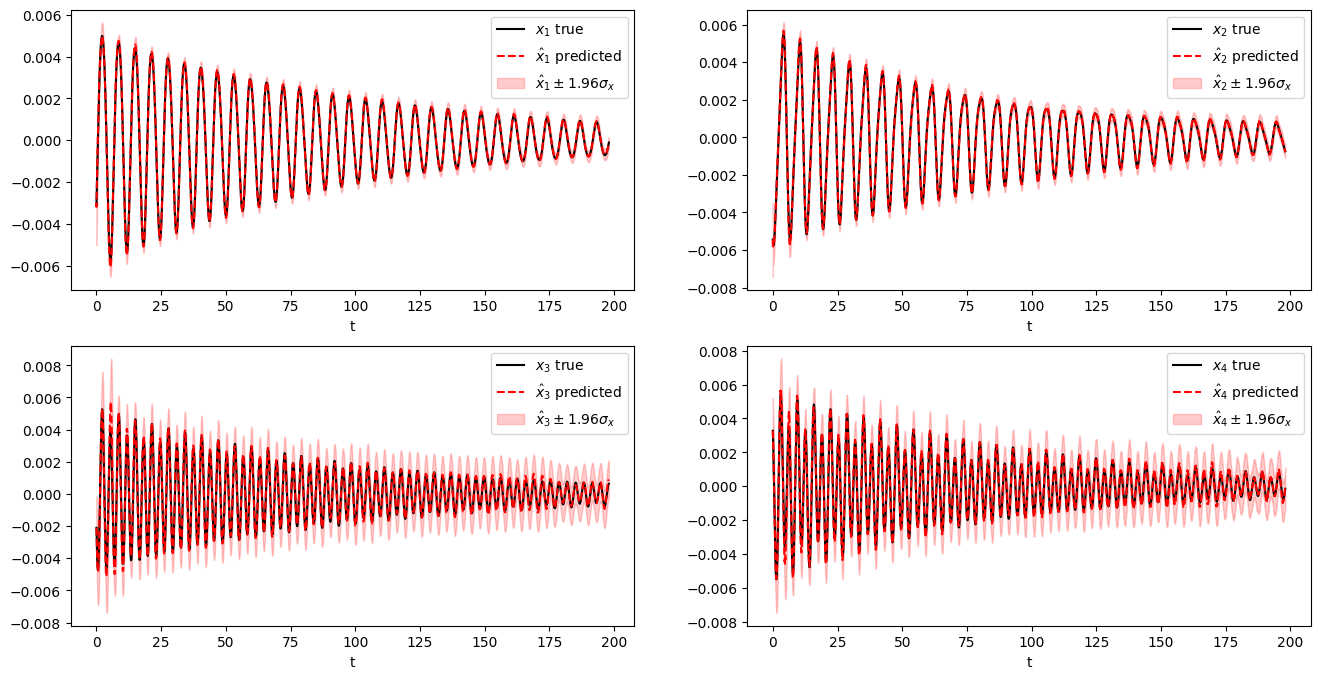

In [16]:
plt.figure(figsize=[16, 8])

for i in range(4):
    plt.subplot(221 + i)
    plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], X_test_tdc[idx_test][n_time_steps_start_plot:n_time_steps_stop_plot, i], 'k', label=f"$x_{{{i+1}}}$ true")
    plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis[i, n_time_steps_start_plot:n_time_steps_stop_plot], 'r--', label=f"$\hat{{x}}_{{{i+1}}}$ predicted")
    plt.fill_between(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_piu_sigma[i, n_time_steps_start_plot:n_time_steps_stop_plot], xhat_taxis_meno_sigma[i, n_time_steps_start_plot:n_time_steps_stop_plot], color='red', alpha=0.2, label=f"$\hat{{x}}_{{{i+1}}} \\pm 1.96\sigma_x$")
    plt.xlabel('t')
    plt.legend()

plt.show()


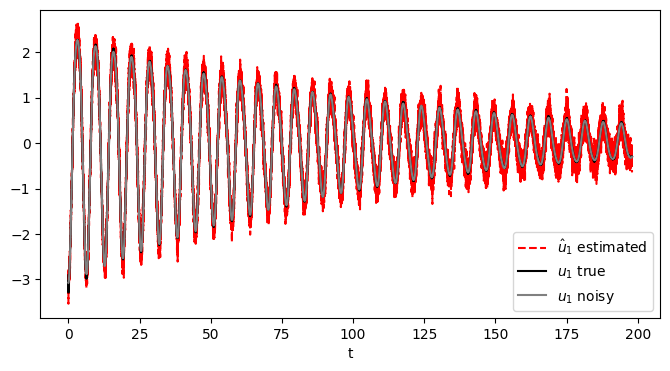

In [17]:
#%% observed variable
plt.figure(figsize = [8,4])
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot],out_axis[n_time_steps_start_plot:n_time_steps_stop_plot],'r--', label = '$\hat{u}_1$ estimated')
plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot],obs_taxis[0,n_time_steps_start_plot:n_time_steps_stop_plot],'k', label = '$u_1$ true')
if add_noise:
    plt.plot(t_axis[n_time_steps_start_plot:n_time_steps_stop_plot],out_no_noise_axis[n_time_steps_start_plot:n_time_steps_stop_plot],'gray', label = '$u_1$ noisy')
plt.legend()
plt.xlabel('t')
plt.show()
